# Import libraries

In [10]:
import os
import pandas as pd

In [2]:
base_dirs = [
    r"Nkhoma_data/Inpatient list Surgery",
    r"Nkhoma_data/Poor Patient Funds",
    r"Nkhoma_data/Data",
]

def is_excel(path: str) -> bool:
    p = path.lower()
    return p.endswith(".xlsx") or p.endswith(".xls")

rows = []

for base in base_dirs:
    for root, _, files in os.walk(base):
        for fn in files:
            full = os.path.join(root, fn)
            if not is_excel(full):
                continue

            try:
                xls = pd.ExcelFile(full)
                for sheet in xls.sheet_names:
                    try:
                        df = pd.read_excel(full, sheet_name=sheet)
                        df.columns = [str(c).strip() for c in df.columns]
                        n_rows, n_cols = df.shape

                        # basic diagnostics
                        missing_cells = int(df.isna().sum().sum())
                        missing_cols = int((df.isna().mean() > 0.5).sum())
                        dup_rows = int(df.duplicated().sum())

                        rows.append({
                            "file": full,
                            "sheet": sheet,
                            "rows": n_rows,
                            "cols": n_cols,
                            "missing_cells": missing_cells,
                            "cols_gt50pct_missing": missing_cols,
                            "duplicate_rows": dup_rows,
                            "column_names": ", ".join(df.columns[:40]) + (" ..." if len(df.columns) > 40 else ""),
                        })
                    except Exception as e_sheet:
                        rows.append({
                            "file": full,
                            "sheet": sheet,
                            "rows": None,
                            "cols": None,
                            "missing_cells": None,
                            "cols_gt50pct_missing": None,
                            "duplicate_rows": None,
                            "column_names": None,
                            "error": f"sheet_read_error: {e_sheet}",
                        })

            except Exception as e_file:
                rows.append({
                    "file": full,
                    "sheet": None,
                    "rows": None,
                    "cols": None,
                    "missing_cells": None,
                    "cols_gt50pct_missing": None,
                    "duplicate_rows": None,
                    "column_names": None,
                    "error": f"file_open_error: {e_file}",
                })

audit = pd.DataFrame(rows).sort_values(["file", "sheet"], na_position="last")
out_path = "db_audit_summary.csv"
audit.to_csv(out_path, index=False)

print(f"Saved audit -> {out_path}")
print(audit.head(20).to_string(index=False))


/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell G141 is marked as a date but the serial value 6693834.0 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell E259 is marked as a date but the serial value 984322580.0 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell E260 is marked as a date but the serial value 997768636.0 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/home/mat2m10/.pyenv/versions/3.1

Saved audit -> db_audit_summary.csv
                                                                      file                 sheet  rows  cols  missing_cells  cols_gt50pct_missing  duplicate_rows                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   column_names
                                   Nkhoma_data/Data/Old Theatre Books.xlsx              Tabelle1    40     2              7                     0               2                                                                                                                  

/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
import pandas as pd
import numpy as np

def profile_df(df: pd.DataFrame, sample_n: int = 3) -> pd.DataFrame:
    out = []
    for c in df.columns:
        s = df[c]
        n = len(s)
        n_missing = int(s.isna().sum())
        pct_missing = (n_missing / n * 100) if n else np.nan

        # unique counts (ignore NaN)
        try:
            n_unique = int(s.nunique(dropna=True))
        except Exception:
            n_unique = None

        # a few example non-null values
        examples = []
        try:
            examples = s.dropna().astype(str).head(sample_n).tolist()
        except Exception:
            pass

        out.append({
            "col": str(c),
            "dtype": str(s.dtype),
            "n": n,
            "n_missing": n_missing,
            "pct_missing": round(pct_missing, 2) if pd.notna(pct_missing) else np.nan,
            "n_unique": n_unique,
            "examples": " | ".join(examples),
            "is_unnamed": str(c).strip().lower().startswith("unnamed:"),
        })

    prof = pd.DataFrame(out).sort_values(["is_unnamed", "pct_missing"], ascending=[False, False])
    return prof

# --- choose ONE sheet to start (edit these two lines) ---
file_path = r"Nkhoma_data/Data/Theatre_Book-Database 2024 Auswertung-Arbeitsversion.xlsx"
sheet_name = "Main Data"

df = pd.read_excel(file_path, sheet_name=sheet_name)
df.columns = [str(c).strip() for c in df.columns]

prof = profile_df(df)
display(prof)

print("Rows, Cols:", df.shape)
print("Top columns by missingness:")
display(prof.sort_values("pct_missing", ascending=False).head(15))


/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,col,dtype,n,n_missing,pct_missing,n_unique,examples,is_unnamed
30,Unnamed: 30,float64,3488,3488,100.00,0,,True
31,Unnamed: 31,object,3488,3480,99.77,1,Calculated: do not fill out | Calculated: do n...,True
32,Unnamed: 32,object,3488,3480,99.77,1,Fill out for every patient | Fill out for ever...,True
33,Unnamed: 33,object,3488,3480,99.77,1,Fill out for all PAACS cases | Fill out for al...,True
34,Unnamed: 34,object,3488,3480,99.77,1,Fill out if possible | Fill out if possible ...,True
1,Hospital ID #,float64,3488,3488,100.00,0,,False
10,2nd Assistent,object,3488,3270,93.75,14,Other | Other | Other,False
19,Side,object,3488,3132,89.79,6,right | right | left,False
21,Procedure (Free Text),object,3488,2859,81.97,386,Modified Grahams patch | Untangled loops of sm...,False
27,ASA-Score,object,3488,2624,75.23,10,ASA 3 | ASA 2 | ASA 3,False


Rows, Cols: (3488, 35)
Top columns by missingness:


,col,dtype,n,n_missing,pct_missing,n_unique,examples,is_unnamed
30,Unnamed: 30,float64,3488,3488,100.00,0,,True
1,Hospital ID #,float64,3488,3488,100.00,0,,False
31,Unnamed: 31,object,3488,3480,99.77,1,Calculated: do not fill out | Calculated: do n...,True
32,Unnamed: 32,object,3488,3480,99.77,1,Fill out for every patient | Fill out for ever...,True
33,Unnamed: 33,object,3488,3480,99.77,1,Fill out for all PAACS cases | Fill out for al...,True
34,Unnamed: 34,object,3488,3480,99.77,1,Fill out if possible | Fill out if possible ...,True
10,2nd Assistent,object,3488,3270,93.75,14,Other | Other | Other,False
19,Side,object,3488,3132,89.79,6,right | right | left,False
21,Procedure (Free Text),object,3488,2859,81.97,386,Modified Grahams patch | Untangled loops of sm...,False
27,ASA-Score,object,3488,2624,75.23,10,ASA 3 | ASA 2 | ASA 3,False


In [4]:
import pandas as pd
import re

def clean_structure(df: pd.DataFrame, missing_drop_threshold=0.98) -> pd.DataFrame:
    df = df.copy()

    # 1. Normalize column names
    def norm(c):
        c = str(c).strip()
        c = re.sub(r"\s+", " ", c)
        c = c.replace("#", "num")
        c = c.replace("/", "_")
        c = c.replace("(", "").replace(")", "")
        c = c.replace("-", "_")
        return c.lower()

    df.columns = [norm(c) for c in df.columns]

    # 2. Drop Excel artefact columns (Unnamed + almost entirely missing)
    missing_frac = df.isna().mean()

    drop_cols = [
        c for c in df.columns
        if c.startswith("unnamed")
        or missing_frac[c] >= missing_drop_threshold
    ]

    df = df.drop(columns=drop_cols)

    # 3. Remove rows that are completely empty
    df = df.dropna(how="all")

    return df


# ---- apply to your data ----
df_clean = clean_structure(df)

print("Before:", df.shape)
print("After :", df_clean.shape)
print("\nRemaining columns:")
for c in df_clean.columns:
    print(" -", c)


Before: (3488, 35)
After : (3407, 29)

Remaining columns:
 - theatre book num
 - date of surgery
 - first name
 - last name
 - age years
 - sex
 - village
 - surgeon
 - 1st assistent_instructor
 - 2nd assistent
 - anaestesist
 - nurse
 - anesthesia
 - department
 - indication for surgery
 - surgery type
 - final diagnosis category
 - final diagnosis free text
 - side
 - main procedure category
 - procedure free text
 - histology
 - sarting time
 - finishing time
 - urgency
 - surgery severity
 - asa_score
 - year of birth
 - operation time minutes


In [5]:
import pandas as pd
import numpy as np
import re

def _clean_text(s: pd.Series) -> pd.Series:
    return (s.astype("string")
              .str.strip()
              .str.replace(r"\s+", " ", regex=True)
              .replace({"": pd.NA, "nan": pd.NA, "None": pd.NA, "NONE": pd.NA}))

def _parse_time_to_minutes(s: pd.Series) -> pd.Series:
    """
    Accepts values like:
      - "14:15:00", "04:05"
      - pandas Timestamp/time-like
      - weird "00:00:00"
    Returns minutes since midnight (float), NaN if not parseable.
    """
    s2 = s.copy()

    # Try pandas to_datetime (handles many string/time cases)
    t = pd.to_datetime(s2, errors="coerce")

    # For pure times, pandas will set an arbitrary date; extract time part.
    mins = (t.dt.hour * 60 + t.dt.minute).astype("float")

    # If that failed, try a fallback regex on strings
    mask_bad = mins.isna() & s2.notna()
    if mask_bad.any():
        ss = s2[mask_bad].astype(str).str.strip()
        m = ss.str.extract(r"^(?P<h>\d{1,2}):(?P<m>\d{2})(?::(?P<s>\d{2}))?$")
        h = pd.to_numeric(m["h"], errors="coerce")
        mm = pd.to_numeric(m["m"], errors="coerce")
        mins.loc[mask_bad] = (h * 60 + mm)

    return mins

def clean_typed(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ---- text normalization for key categorical columns ----
    for c in [
        "theatre book num","first name","last name","village","surgeon",
        "1st assistent_instructor","2nd assistent","anaestesist","nurse",
        "anesthesia","department","indication for surgery","surgery type",
        "final diagnosis category","final diagnosis free text","side",
        "main procedure category","procedure free text","histology",
        "urgency","surgery severity","asa_score"
    ]:
        if c in df.columns:
            df[c] = _clean_text(df[c])

    # ---- date ----
    if "date of surgery" in df.columns:
        df["date_of_surgery"] = pd.to_datetime(df["date of surgery"], errors="coerce").dt.date
        df = df.drop(columns=["date of surgery"])

    # ---- sex ----
    if "sex" in df.columns:
        s = df["sex"].str.upper()
        df["sex"] = s.replace({
            "MALE": "M", "FEMALE": "F",
            "M.": "M", "F.": "F",
        })

    # ---- side ----
    if "side" in df.columns:
        s = df["side"].str.lower()
        s = s.replace({
            "rt": "right", "lt": "left",
            "r": "right", "l": "left",
            "bilat": "bilateral", "both": "bilateral"
        })
        df["side"] = s

    # ---- ASA score (extract number 1-5) ----
    if "asa_score" in df.columns:
        m = df["asa_score"].str.extract(r"([1-5])")
        df["asa"] = pd.to_numeric(m[0], errors="coerce")
        # keep original too, but you can drop it later if you want

    # ---- times + duration ----
    if "sarting time" in df.columns:
        df["start_min"] = _parse_time_to_minutes(df["sarting time"])
    if "finishing time" in df.columns:
        df["finish_min"] = _parse_time_to_minutes(df["finishing time"])

    if "start_min" in df.columns and "finish_min" in df.columns:
        dur = df["finish_min"] - df["start_min"]
        # handle overnight cases (finish after midnight)
        dur = dur.where(dur >= 0, dur + 24*60)
        df["op_duration_min"] = dur

    # ---- operation time (minutes) column is messy ("0" vs "00:00:00") ----
    if "operation time minutes" in df.columns:
        s = df["operation time minutes"]
        # numeric first
        num = pd.to_numeric(s, errors="coerce")
        # if not numeric, try parse as time and convert to minutes
        mins = _parse_time_to_minutes(s)
        df["operation_time_min_reported"] = num.fillna(mins)
        # keep original if you want; otherwise drop later

    # ---- year of birth sanity ----
    if "year of birth" in df.columns:
        yob = pd.to_numeric(df["year of birth"], errors="coerce")
        # drop obviously wrong values
        yob = yob.where((yob >= 1900) & (yob <= 2030))
        df["year_of_birth"] = yob
        # don't drop original yet

    # ---- age years numeric ----
    if "age years" in df.columns:
        age = pd.to_numeric(df["age years"], errors="coerce")
        age = age.where((age >= 0) & (age <= 120))
        df["age_years"] = age

    return df


df_typed = clean_typed(df_clean)

print("Typed df shape:", df_typed.shape)
print("\nKey new columns present:")
for c in ["date_of_surgery","asa","start_min","finish_min","op_duration_min","operation_time_min_reported","year_of_birth","age_years"]:
    if c in df_typed.columns:
        print(" -", c)

print("\nQuick checks:")
print("ASA value counts (incl NaN):")
print(df_typed["asa"].value_counts(dropna=False) if "asa" in df_typed.columns else "no asa")

print("\nOp duration summary (minutes):")
print(df_typed["op_duration_min"].describe() if "op_duration_min" in df_typed.columns else "no op_duration_min")


Typed df shape: (3407, 36)

Key new columns present:
 - date_of_surgery
 - asa
 - start_min
 - finish_min
 - op_duration_min
 - operation_time_min_reported
 - year_of_birth
 - age_years

Quick checks:
ASA value counts (incl NaN):
asa
<NA>    2544
1        501
2        252
3         91
4         19
Name: count, dtype: Int64

Op duration summary (minutes):
count    1106.000000
mean       71.329114
std       141.339123
min         0.000000
25%        24.000000
50%        45.000000
75%        71.000000
max      1436.000000
Name: op_duration_min, dtype: float64


In [6]:
import pandas as pd
import numpy as np

def quality_and_stats(df: pd.DataFrame) -> dict:
    out = {}

    # ---- basic counts ----
    out["n_rows"] = len(df)

    # ---- duplicates ----
    if "theatre book num" in df.columns:
        dup_mask = df["theatre book num"].duplicated(keep=False)
        out["n_duplicate_cases"] = int(dup_mask.sum())
    else:
        out["n_duplicate_cases"] = None

    # ---- missingness (key variables) ----
    key_vars = [
        "date_of_surgery","sex","age_years","department",
        "urgency","asa","op_duration_min"
    ]

    miss = []
    for c in key_vars:
        if c in df.columns:
            miss.append({
                "variable": c,
                "n_missing": int(df[c].isna().sum()),
                "pct_missing": round(df[c].isna().mean() * 100, 1)
            })
    out["missingness"] = pd.DataFrame(miss)

    # ---- ASA distribution ----
    if "asa" in df.columns:
        out["asa_dist"] = (
            df["asa"]
            .value_counts(dropna=False)
            .sort_index()
            .rename("n")
            .to_frame()
        )

    # ---- urgency ----
    if "urgency" in df.columns:
        out["urgency_dist"] = (
            df["urgency"]
            .value_counts(dropna=False)
            .rename("n")
            .to_frame()
        )

    # ---- department case mix ----
    if "department" in df.columns:
        out["dept_cases"] = (
            df["department"]
            .value_counts()
            .rename("n")
            .to_frame()
        )

    # ---- operation duration sanity ----
    if "op_duration_min" in df.columns:
        dur = df["op_duration_min"]
        out["duration_summary"] = dur.describe()
        out["n_zero_duration"] = int((dur == 0).sum())
        out["n_gt_12h"] = int((dur > 12*60).sum())

    # ---- monthly volume ----
    if "date_of_surgery" in df.columns:
        s = pd.to_datetime(df["date_of_surgery"], errors="coerce")
        out["monthly_volume"] = (
            s.dropna()
             .dt.to_period("M")
             .value_counts()
             .sort_index()
             .rename("n_cases")
             .to_frame()
        )

    return out


stats = quality_and_stats(df_typed)

print("Total rows:", stats["n_rows"])
print("Duplicate cases:", stats["n_duplicate_cases"])

print("\nMissingness:")
display(stats["missingness"])

print("\nASA distribution:")
display(stats["asa_dist"])

print("\nUrgency distribution:")
display(stats["urgency_dist"])

print("\nDepartment case mix:")
display(stats["dept_cases"].head(10))

print("\nDuration summary:")
print(stats["duration_summary"])
print("Zero duration cases:", stats["n_zero_duration"])
print(">12h cases:", stats["n_gt_12h"])

print("\nMonthly volume (first 12 rows):")
display(stats["monthly_volume"].head(12))


Total rows: 3407
Duplicate cases: 1278

Missingness:


,variable,n_missing,pct_missing
0,date_of_surgery,1278,37.5
1,sex,1282,37.6
2,age_years,1287,37.8
3,department,1276,37.5
4,urgency,2416,70.9
5,asa,2544,74.7
6,op_duration_min,2301,67.5



ASA distribution:


,n
asa,
1,501
2,252
3,91
4,19
<NA>,2544



Urgency distribution:


,n
urgency,
<NA>,2416
Elective,621
Emergency,357
Urgent,11
elective,1
ELective,1



Department case mix:


,n
department,
Gen_Surg,1052
ObsGyn,933
Ortho,142
GEn_Surg,1
1053,1
933,1
142,1



Duration summary:
count    1106.000000
mean       71.329114
std       141.339123
min         0.000000
25%        24.000000
50%        45.000000
75%        71.000000
max      1436.000000
Name: op_duration_min, dtype: float64
Zero duration cases: 1
>12h cases: 22

Monthly volume (first 12 rows):


,n_cases
date_of_surgery,
1905-10,1
2024-01,128
2024-02,161
2024-03,178
2024-04,188
2024-05,185
2024-06,176
2024-07,203
2024-08,191


In [7]:
import pandas as pd
import numpy as np

def clean_categories_and_dedup(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ---- drop impossible dates (e.g. 1905) ----
    if "date_of_surgery" in df.columns:
        d = pd.to_datetime(df["date_of_surgery"], errors="coerce")
        df = df.loc[(d.isna()) | (d.dt.year >= 2000)]

    # ---- normalize urgency ----
    if "urgency" in df.columns:
        u = df["urgency"].str.strip().str.lower()
        u = u.replace({
            "elective": "Elective",
            "emergency": "Emergency",
            "urgent": "Urgent"
        })
        df["urgency"] = u.where(u.isin(["Elective", "Emergency", "Urgent"]))

    # ---- normalize department ----
    if "department" in df.columns:
        d = df["department"].astype(str).str.strip()
        d = d.replace({
            "Gen_Surg": "Gen_Surg",
            "GEn_Surg": "Gen_Surg",
            "ObsGyn": "ObsGyn",
            "Ortho": "Ortho"
        })
        # remove numeric junk
        d = d.where(d.isin(["Gen_Surg", "ObsGyn", "Ortho"]))
        df["department"] = d

    # ---- de-duplicate by Theatre Book number ----
    if "theatre book num" in df.columns:
        # completeness score = number of non-missing fields
        non_missing = df.notna().sum(axis=1)
        df["_completeness"] = non_missing

        df = (
            df.sort_values("_completeness", ascending=False)
              .drop_duplicates(subset="theatre book num", keep="first")
              .drop(columns="_completeness")
        )

    return df


df_final = clean_categories_and_dedup(df_typed)

print("Before:", df_typed.shape)
print("After :", df_final.shape)

print("\nUrgency distribution:")
print(df_final["urgency"].value_counts(dropna=False))

print("\nDepartment distribution:")
print(df_final["department"].value_counts(dropna=False))

print("\nRemaining duplicate Theatre Book #:",
      df_final["theatre book num"].duplicated().sum())


Before: (3407, 36)
After : (2129, 36)

Urgency distribution:
urgency
<NA>         1138
Elective      623
Emergency     357
Urgent         11
Name: count, dtype: Int64

Department distribution:
department
Gen_Surg    1053
ObsGyn       933
Ortho        142
NaN            1
Name: count, dtype: int64

Remaining duplicate Theatre Book #: 0


In [8]:
import pandas as pd
import numpy as np

def median_iqr(s):
    s = s.dropna()
    if len(s) == 0:
        return "NA"
    return f"{s.median():.0f} [{s.quantile(0.25):.0f}–{s.quantile(0.75):.0f}]"

rows = []

N = len(df_final)
rows.append(("Cases, n", f"{N}"))

# ---- age ----
rows.append(("Age, years, median [IQR]", median_iqr(df_final["age_years"])))

# ---- sex ----
sex_counts = df_final["sex"].value_counts(dropna=True)
for k in ["F", "M"]:
    if k in sex_counts:
        rows.append((f"Sex: {k}, n (%)",
                     f"{sex_counts[k]} ({sex_counts[k]/N*100:.1f})"))

# ---- department ----
dept_counts = df_final["department"].value_counts()
for k, v in dept_counts.items():
    rows.append((f"Department: {k}, n (%)",
                 f"{v} ({v/N*100:.1f})"))

# ---- urgency ----
urg_counts = df_final["urgency"].value_counts()
for k, v in urg_counts.items():
    rows.append((f"Urgency: {k}, n (%)",
                 f"{v} ({v/N*100:.1f})"))

# ---- ASA ----
asa_counts = df_final["asa"].value_counts().sort_index()
for k, v in asa_counts.items():
    rows.append((f"ASA {int(k)}, n (%)",
                 f"{v} ({v/N*100:.1f})"))

# ---- operation duration ----
rows.append(("Operation duration, min, median [IQR]",
             median_iqr(df_final["op_duration_min"])))

table1 = pd.DataFrame(rows, columns=["Characteristic", "Value"])

display(table1)


,Characteristic,Value
0,"Cases, n",2129
1,"Age, years, median [IQR]",32 [22–51]
2,"Sex: F, n (%)",1284 (60.3)
3,"Sex: M, n (%)",841 (39.5)
4,"Department: Gen_Surg, n (%)",1053 (49.5)
5,"Department: ObsGyn, n (%)",933 (43.8)
6,"Department: Ortho, n (%)",142 (6.7)
7,"Urgency: Elective, n (%)",623 (29.3)
8,"Urgency: Emergency, n (%)",357 (16.8)
9,"Urgency: Urgent, n (%)",11 (0.5)


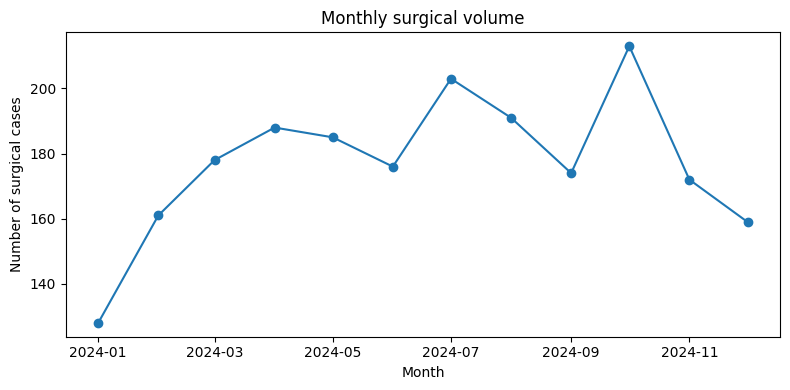

date_of_surgery
2024-01-01    128
2024-02-01    161
2024-03-01    178
2024-04-01    188
2024-05-01    185
2024-06-01    176
2024-07-01    203
2024-08-01    191
2024-09-01    174
2024-10-01    213
2024-11-01    172
2024-12-01    159
Freq: MS, Name: count, dtype: int64


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare monthly counts
s = pd.to_datetime(df_final["date_of_surgery"], errors="coerce")
monthly = (
    s.dropna()
     .dt.to_period("M")
     .value_counts()
     .sort_index()
     .to_timestamp()
)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(monthly.index, monthly.values, marker="o")
plt.xlabel("Month")
plt.ylabel("Number of surgical cases")
plt.title("Monthly surgical volume")
plt.tight_layout()
plt.show()

print(monthly)
